In [2]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl
import wandb

from src import *

In [3]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load the growing CA part
old_CA = NeuralCA(device=device)
old_CA.load("Pretrained_models/firework_growing.pt")

for param in old_CA.parameters():
   param.requires_grad = False

Successfully loaded model!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


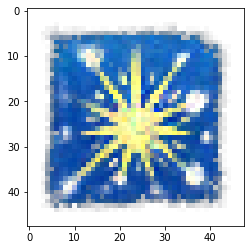

In [6]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 1, old_CA, iter_func=ExponentialSampler(max=50))
pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

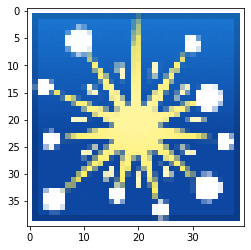

In [7]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [8]:
# Send target to device
target = target.to(device)

In [9]:
# Load the virus CA part
new_CA = NeuralCA(device=device)
new_CA.load("Pretrained_models/mask/mask 80.0% persist.pt")
model = VirusCA(old_CA, new_CA, mutation_probability=0.8)
model.initialized = False

Successfully loaded model!


In [ ]:
from collections import OrderedDict

results = OrderedDict()

for i in range(19, 10, -1):
    mutation_probability = i / 20

    new_CA.load(f"Pretrained_models/mask/mask {mutation_probability*100:.1f}% persist.pt")

    model = VirusCA(old_CA, new_CA, mutation_probability=mutation_probability)
    model.initialized = False

    loss = model.test_CA(NCALoss(pad(target, TARGET_PADDING)), pool.sample(64)[0].to(device), evolution_iters=3000)

    print(loss[-1])
    results[mutation_probability] = loss

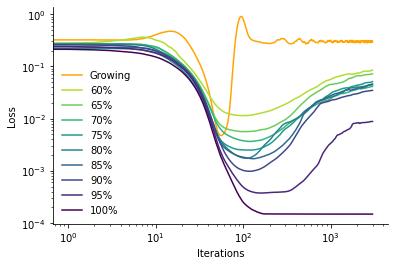

In [67]:
fig, ax = plt.subplots()

ax.loglog(results[0.], label="Growing", color="orange")

for k, v in sorted(results.items()):
    if k < 0.6: continue
    colormap = pl.cm.get_cmap("viridis")
    ax.loglog(v, label=f"{k*100:.0f}%", color=colormap(2.2*(1-k)))

pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pl.savefig("Presentation_images/mask_by_percentage.svg", dpi=300)
pl.show()

In [30]:
model = VirusCA(old_CA, new_CA, mutation_probability=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


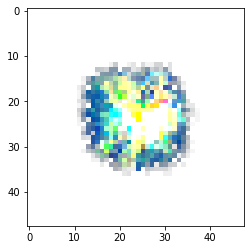

In [9]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 1, old_CA, iter_func=ExponentialSampler(max=50))
pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

In [ ]:
# Train the model
wandb.watch(model, log_freq=64)

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=1e-3)
criterion = NCALoss(pad(target, TARGET_PADDING))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=50, scheduler=scheduler, kind="persist", batch_size=4, skip_update=2, skip_damage=2)

In [25]:
wandb.finish()

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/lettera/neural_cellular_automata-pytorch_ca/uyabvw7h/file_stream
NoneType: None


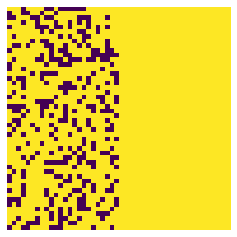

In [48]:
img = T.Resize(48*8, T.InterpolationMode.NEAREST)(model.new_cells).cpu()
pl.matshow(img[0, 0])
save_image(GrayscaletoCmap(img[0, 0]) / 255, "mask new 2.png")
pl.axis('off')
pl.savefig("mask.png")

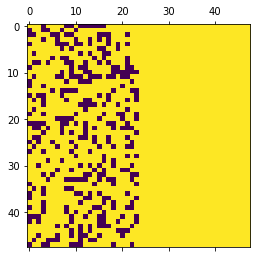

In [39]:
pl.matshow(model.new_cells[0, 0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


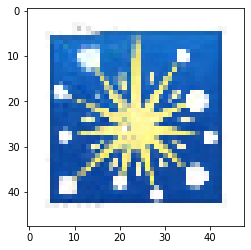

In [42]:
imshow(model.evolve(pool.sample(1)[0].to(device), 1000)[0].cpu())

In [51]:
_ = switch_video(old_CA, model, init_state=make_seed(1, N_CHANNELS, IMAGE_SIZE, alpha_channel=3, device=device), fname="prova.mp4")

In [26]:
new_mask = model.new_cells.clone()
new_mask[:, :, :, 24:] = 1.
model.set_cell_mask(new_mask)

In [ ]:
# Show losses
model.plot_losses()

In [ ]:
# Show a sample from the pool images
imshow(pool.sample(1)[0][0])

In [13]:
# Save the model and upload it to wandb
model.new_CA.save(f"Pretrained_models/mask/mask {mask_percentage*100}% persist.pt")

wandb.log({"state_dict": model.new_CA.state_dict()})
wandb.save(f"Pretrained_models/mask/mask {mask_percentage*100}% persist.pt")

Successfully saved model!


['/home/lettera/Desktop/neural_cellular_automata/pytorch_ca/wandb/run-20211026_171534-30ewk9yt/files/Pretrained_models/mask/mask 95.0% persist.pt']

In [ ]:
# Upload pool images to wandb
imgs = []

for i in range(12):
    img = np.asarray(pool.sample(1)[0][0].cpu().permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

In [ ]:
# Show the virus cell mask
pl.matshow(model.new_cells.cpu()[0,0])

In [ ]:
# Upload mask to wandb
wandb.log({"mask": wandb.Image(model.new_cells.cpu()[0,0])})

In [21]:
# Make a switch video
_ , _ = switch_video(old_CA, model, fname="mask 70%.mp4")

In [20]:
# Upload the evolution video to wandb
wandb.log({"video": wandb.Video("prova.mp4", "video", fps=10, format="mp4")})

FileNotFoundError: [Errno 2] No such file or directory: 'prova.mp4'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


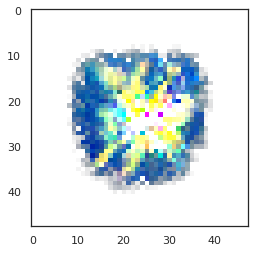

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


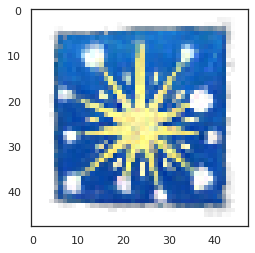

In [92]:
# Evolve the CA for 200 iters and plot it
x, _ = pool.sample(1)
imshow(x[0])
x = x.to(device)
model.update_cell_mask(x)

with torch.no_grad():
    x = model.evolve(x, 30)

imshow(x[0].cpu())

img = T.Resize(48*8, T.InterpolationMode.NEAREST)(x[0:1]).cpu()
save_image(RGBAtoRGB(img[:, :4])/255, "mask new 2.png")

In [ ]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))

In [ ]:
wandb.finish()